# Predizione tutte le waves

In [ ]:
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from aidam.math_utils import moving_function_rev1
#from aidam.aicharts import get_subplot_cells_sequence, confplot_ax,auto_grid_shape
#from aidam.faga.curve_fit import FagaCurveFit
from scipy.optimize import curve_fit
from datetime import datetime, timedelta
from aidam.miscellanea_utils import find_matlabstyle

from covid_lib import read_covid_data, find_day_index

## Lettura dati

In [ ]:
trend,regioni,giorni,giorno_settimana,popolazione,day_counter=read_covid_data('stored_data.pkl')

## Estrapolazione second wave

Inizio nominale second wave: 2021-06-28T17:00:00


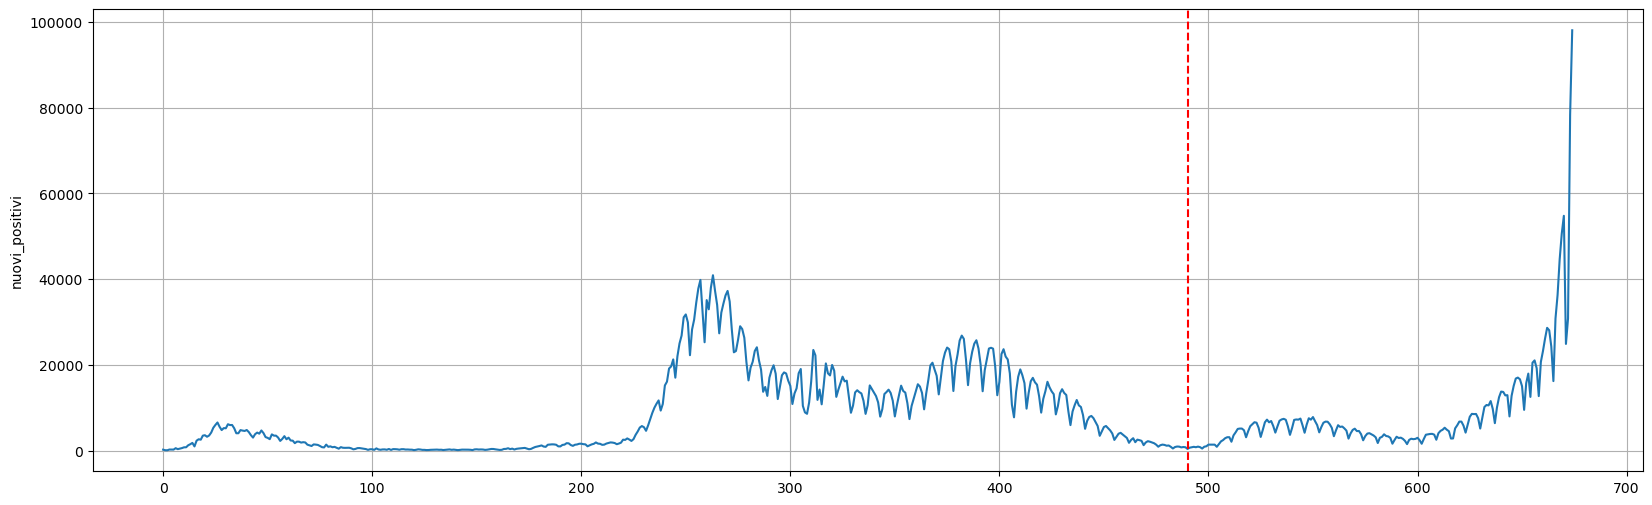

Valore nuovi_positivi a inizio second wave: 389.000000


In [7]:
indicatore='nuovi_positivi'
regione='Italia'

# giorno di inizio second wave
if indicatore=='terapia_intensiva':
    sw_start=150
if indicatore=='deceduti_giornalieri':
    sw_start=150
if indicatore=='nuovi_positivi':
    sw_start=490

    
print('Inizio nominale second wave: %s'%giorni[sw_start])



fig,ax=plt.subplots(1,figsize=(20,6))
ax.plot(day_counter,trend[indicatore][regione])
ax.grid()
ax.set_ylabel(indicatore)
ax.axvline(sw_start,c='r',ls='--')
plt.show()

Y=trend[indicatore][regione][sw_start:]


print('Valore %s a inizio second wave: %f'%(indicatore,trend[indicatore][regione][sw_start]))

## Multi-gaussiane

In [ ]:
def generic_gaussian(t,a,b,c):
    # a: altezza picco
    # b: giorno centrale
    # c: deviazione standard
    return a*np.exp(-((t-b)**2)/(2*c**2))

def multi_gaussian_creator(t,num_gaussiane,pars):
    temp=0
    for i in range(num_gaussiane):
        temp+=generic_gaussian(t,*pars[i*3:i*3+3])
    return temp

In [34]:
num_gaussians=3

my_multi_gaussian=lambda t,*pars: multi_gaussian_creator(t,num_gaussians,pars)
#start_point=[1,1,1,1,1,1]

# versione automatica
minimi=num_gaussians*[0,0,0]
massimi=num_gaussians*[2*np.max(Y),np.round(len(Y)*1),np.round(0.5*len(Y))]
'''
# versione manuale
# data picco
minimi[7]=len(Y)-10
massimi[7]=len(Y)+20
# altezza picco
minimi[6]=0.8*np.max(Y)
massimi[6]=1.1*np.max(Y)
'''

bounds=(minimi,massimi)
start_point=(np.array(bounds[0])+np.array(bounds[1]))/2

#three_gaussians=lambda t,*pars: multi_gaussian(t,3,pars)
#start_point=[1,1,1,1,1,1,1,1,1]

'''
three_gaussians=lambda t,*pars: multi_gaussian(t,3,pars)
# bounds per 3 gaussiane su nuovi positivi
bounds=([1000,10,0,20000,220,0,10000,300,0],[10000,100,100,50000,300,100,50000,500,100])
start_point=(np.array(bounds[0])+np.array(bounds[1]))/2
'''

'\nthree_gaussians=lambda t,*pars: multi_gaussian(t,3,pars)\n# bounds per 3 gaussiane su nuovi positivi\nbounds=([1000,10,0,20000,220,0,10000,300,0],[10000,100,100,50000,300,100,50000,500,100])\nstart_point=(np.array(bounds[0])+np.array(bounds[1]))/2\n'

In [35]:
print(bounds)
print(start_point)

([0, 0, 0, 0, 0, 0, 0, 0, 0], [196060.0, 185, 92.0, 196060.0, 185, 92.0, 196060.0, 185, 92.0])
[9.803e+04 9.250e+01 4.600e+01 9.803e+04 9.250e+01 4.600e+01 9.803e+04
 9.250e+01 4.600e+01]


In [36]:
modello_usato=my_multi_gaussian
#solution,pcov=curve_fit(modello_usato,np.arange(len(Y)),Y,p0=start_point)

# questo per limitare i giorni per il tuning
no_last_days=0

#solution,pcov=curve_fit(modello_usato,np.arange(len(Y)),Y,bounds=bounds,p0=start_point)
if no_last_days>0:
    solution,pcov=curve_fit(modello_usato,np.arange(len(Y)-no_last_days),Y[:-no_last_days],bounds=bounds,p0=start_point)
else:
    solution,pcov=curve_fit(modello_usato,np.arange(len(Y)),Y,bounds=bounds,p0=start_point)

solution

array([3.23598341e+04, 1.85000000e+02, 1.75534952e+01, 1.96058058e+05,
       1.83535499e+02, 3.07126387e-01, 5.03511633e+03, 9.79244623e+01,
       9.20000000e+01])

## Simulazione

In [37]:
simulation_days=np.arange(len(Y)+90)
y_pred=np.array(list(map(lambda x:modello_usato(x,*solution),simulation_days)))

Preparazione date

- creo il giorno 0 nel formato *datetime* per poi creare i nuovi plot su questa base
- creo una lista di giorni (in formato di stringhe) partendo dal giorno0

In [38]:
giorno0=datetime.strptime(giorni[sw_start][0:10], "%Y-%m-%d")
str_giorni=[]
for d in range(500):
    str_giorni.append((giorno0+timedelta(d)).strftime("%Y-%m-%d"))
str_giorni=np.array(str_giorni)

oggi=datetime.strftime(datetime.now(), "%Y-%m-%d")
indice_oggi=find_matlabstyle(str_giorni,lambda x:x==oggi)[0]

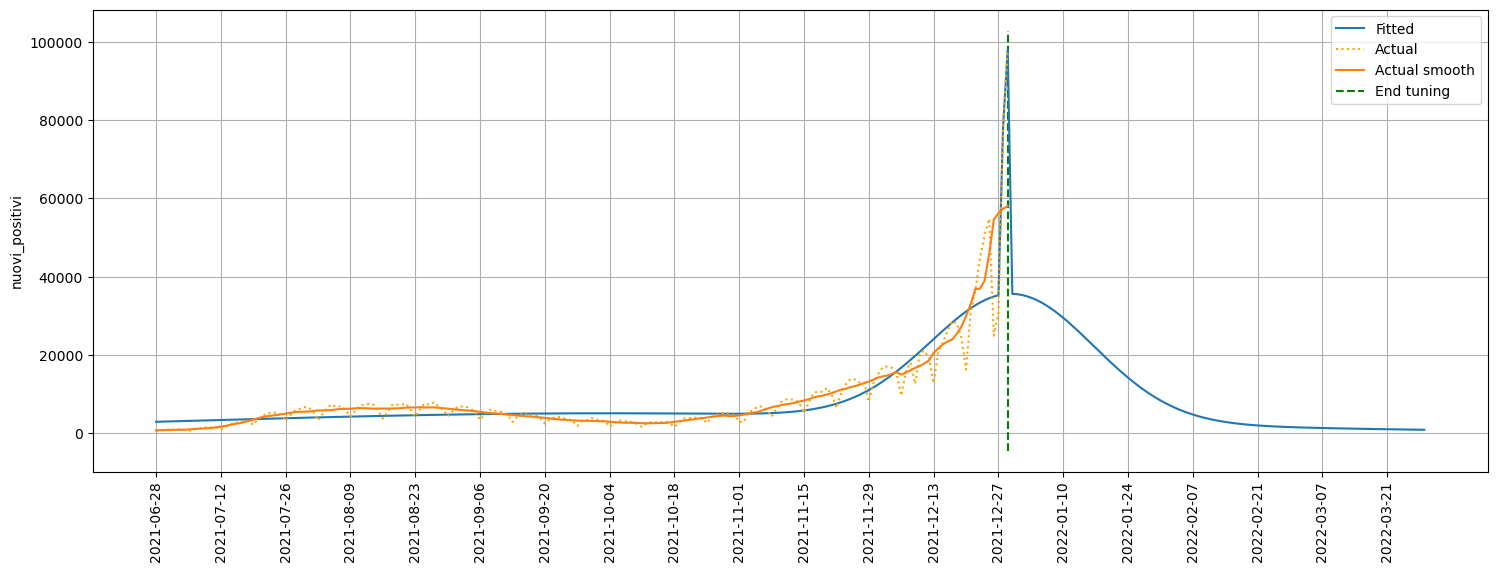

In [39]:
fig,ax=plt.subplots(1,figsize=(18,6))
ax.plot(simulation_days,y_pred,label='Fitted',linestyle='-')
ax.plot(range(len(Y)),Y,label='Actual',linestyle=':',color='orange')
ax.plot(range(len(Y)),moving_function_rev1(Y,np.mean,3,3),label='Actual smooth')
ax.vlines(len(Y)-no_last_days-1,ax.get_ylim()[0],ax.get_ylim()[1],linestyles='--',color='g',label='End tuning')
ax.grid()
ax.set_xticks(list(range(0,len(simulation_days),14)))
ax.set_xticklabels(str_giorni[list(range(0,len(simulation_days),14))],rotation=90)

ax.set_ylabel(indicatore)
ax.legend()
plt.show()

In [40]:
ax.get_ylim()

(-9863.305, 108282.30500000001)

In [41]:
for d in simulation_days:
    if d<len(Y):
        print('[%3d]  %s  Act: %6d Pred: %.1f [Diff: %.1f]'%(d,str_giorni[d],Y[d],y_pred[d],y_pred[d]-Y[d]))
    else:
        print('[%3d]  %s  Act: %6d Pred: %.1f'%(d,str_giorni[d],0,y_pred[d]))   

[  0]  2021-06-28  Act:    389 Pred: 2857.6 [Diff: 2468.6]
[  1]  2021-06-29  Act:    679 Pred: 2890.6 [Diff: 2211.6]
[  2]  2021-06-30  Act:    776 Pred: 2923.8 [Diff: 2147.8]
[  3]  2021-07-01  Act:    882 Pred: 2956.9 [Diff: 2074.9]
[  4]  2021-07-02  Act:    794 Pred: 2990.1 [Diff: 2196.1]
[  5]  2021-07-03  Act:    932 Pred: 3023.3 [Diff: 2091.3]
[  6]  2021-07-04  Act:    808 Pred: 3056.5 [Diff: 2248.5]
[  7]  2021-07-05  Act:    480 Pred: 3089.7 [Diff: 2609.7]
[  8]  2021-07-06  Act:    907 Pred: 3122.8 [Diff: 2215.8]
[  9]  2021-07-07  Act:   1010 Pred: 3156.0 [Diff: 2146.0]
[ 10]  2021-07-08  Act:   1394 Pred: 3189.2 [Diff: 1795.2]
[ 11]  2021-07-09  Act:   1390 Pred: 3222.3 [Diff: 1832.3]
[ 12]  2021-07-10  Act:   1400 Pred: 3255.3 [Diff: 1855.3]
[ 13]  2021-07-11  Act:   1391 Pred: 3288.4 [Diff: 1897.4]
[ 14]  2021-07-12  Act:    888 Pred: 3321.3 [Diff: 2433.3]
[ 15]  2021-07-13  Act:   1534 Pred: 3354.2 [Diff: 1820.2]
[ 16]  2021-07-14  Act:   2153 Pred: 3387.0 [Diff: 1234.